In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, train_test_split, GroupKFold, GroupShuffleSplit,StratifiedShuffleSplit
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
from bayes_opt import BayesianOptimization

C:\Users\lib-moffcirc\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
test = pd.read_csv('poker-hand-testing.data')
train = pd.read_csv('poker-hand-training-true.data')

Text(0.5,0,'Hands')

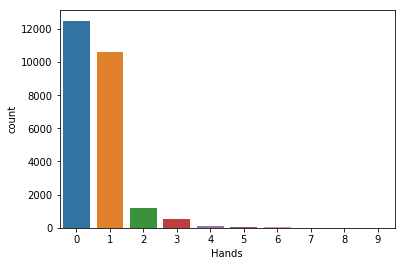

In [3]:
#From the count plot we can see that there is a really big class imbalance in the training data set.
#In order to deal with this, a stratifiedshuffle split will be used on our dataset to ensure that 
#at least some of the samples make it into both the training and validation sets.
sns.countplot('9',data=train)
plt.xlabel('Hands')

In [30]:
y = train['9']
X = train.drop('9',axis=1)
folds = StratifiedShuffleSplit(n_splits=4, test_size=0.2)

In [36]:
def lgbm_evaluate(**params):
    warnings.simplefilter('ignore')
    
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
        
    clf = lgb.LGBMClassifier(**params, n_estimators=20000, nthread=-1)

    test_pred_proba = np.zeros((train.shape[0], 10))
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train, y)):
        X_train, X_valid = train.iloc[train_idx], train.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        
        model = lgb.LGBMClassifier(**params, n_estimators = 10000, n_jobs = -1)
        model.fit(X_train, y_train, 
                eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='multi_logloss',
                verbose=False, early_stopping_rounds=200)

        y_pred_valid = model.predict_proba(X_valid)

        test_pred_proba[valid_idx] = y_pred_valid

    return accuracy_score(y_valid, y_pred_valid.argmax(1))

In [37]:
params = {'colsample_bytree': (0.6, 0.8),
      'learning_rate': (.0001, .5), 
      'num_leaves': (2, 124), 
      'subsample': (0.6, 1), 
      'max_depth': (3, 120), 
      'reg_alpha': (.001, 15.0), 
      'reg_lambda': (.001, 15.0), 
      'min_split_gain': (.001, .03),
      'min_child_weight': (2, 80)}

bo = BayesianOptimization(lgbm_evaluate, params)
bo.maximize(init_points=5, n_iter=10)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.9956   |  0.6865   |  0.3218   |  63.82    |  28.76    |  0.004432 |  96.04    |  11.43    |  0.22     |  0.8725   |
|  2        |  0.9972   |  0.7277   |  0.1659   |  73.21    |  8.345    |  0.02647  |  65.33    |  9.718    |  12.78    |  0.8024   |
|  3        |  0.992    |  0.6412   |  0.4305   |  59.97    |  74.17    |  0.004681 |  50.4     |  5.32     |  0.8157   |  0.8644   |
|  4        |  0.992    |  0.6204   |  0.1584   |  10.89    |  77.19    |  0.008557 |  71.35    |  10.63    |  8.097    |  0.972    |
|  5        |  0.9956   |  0.615    |  0.03954  |  29.72    |  28.61    |  0.006927 |  118.6    |  7.676    |  14.92    |  0.9461   |
|  6        |  0.9992   |  0.6511   |  0.03653  |  3.287    | 

In [38]:
bo.max['params']

{'colsample_bytree': 0.6510667337994955,
 'learning_rate': 0.036530371482843646,
 'max_depth': 3.2872457985145798,
 'min_child_weight': 3.048022537496118,
 'min_split_gain': 0.015520498603420661,
 'num_leaves': 3.3434882559535626,
 'reg_alpha': 4.465244555468376,
 'reg_lambda': 7.744230864916542,
 'subsample': 0.8996181437248253}